In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr
from salishsea_tools import viz_tools
import os

In [2]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [3]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return 1- (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())
    
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = min(years)# years_psf[0], years_pug[0]), years_onc[0])
    endyear = max(years) #years_psf[-1], years_pug[-1]), years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    print (idepth, jdepth)
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # for year in years_psf:
    #     pieces1.append(
    #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d202111, counts1 = plot_and_stats(filter_bad_data(temp1), '202111', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)

    alltogether = d202111
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    # f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    # f.write(alltogether.to_latex(column_format='lcccccccccc', 
    #         formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    # f.close()
    return alltogether, counts1


def get_stats(temp1, name, idepth, jdepth, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    xr = np.arange(vmin, vmax, 0.5)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}

    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

def get_combined(years, years_nanoos, years_ros, years_onc, years_ros_ios, idepth, jdepth, whichdepths, reverse=False,straitn='all'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    for year in years_nanoos:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_{year}0101_{year}1231.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_{year}0101_{year}0131.csv'
        
        if os.path.exists(file_path1):
            pieces1.append(file_path1)
        if os.path.exists(file_path2):
            pieces1.append(file_path2)
    for year in years_ros:
        
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_ros_{year}1001_{year}1231.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_ros_{year}0101_{year}0131.csv'
        
        if os.path.exists(file_path1):
            pieces1.append(file_path1)
        if os.path.exists(file_path2):
            pieces1.append(file_path2)
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
            file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv'
            file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0101_{year}0331.csv'
            file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0401_{year}1031.csv'
            file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}1001_{year}1231.csv'
            file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0101_{year}0430.csv'

            if os.path.exists(file_path1):
                pieces1.append(file_path1)
            if os.path.exists(file_path2):
                pieces1.append(file_path2)
            if os.path.exists(file_path3):
                pieces1.append(file_path3)
            if os.path.exists(file_path4):
                pieces1.append(file_path4)
            if os.path.exists(file_path5):
                pieces1.append(file_path5)
                
    for year in years_ros_ios:
        if straitn == 'all':
            for ii in ['ros','haro2','ejdf2','ssog2']:
                pieces1.append(
                    f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{ii}_{year}0101_{year}1231.csv')
        
        else:        
            pieces1.append(
                f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{straitn}_{year}0101_{year}1231.csv')
            
        
    temp1 = read_pieces(pieces1)
    data_filter = temp1[temp1[modn].notna()]
    d202111 = get_stats(filter_bad_data(data_filter),field , idepth, jdepth, whichdepths, reverse, string)
    
    return data_filter,d202111



### Haro

In [5]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_haro,d_sal_haro = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='haro2')

d_sal_haro.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,124284,-0.106,0.36,0.344,0.96,-0.0858,-2.79,0.13,0.351,-0.164


In [6]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 16
vmin = 5
dbin = 0.2
scale = 24
straitn = 'haro'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_haro,d_temp_haro = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='haro2')

display(d_sal_haro.style.format(myformat).apply(highlight_max_min))
display(d_temp_haro.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,124284,-0.106,0.36,0.344,0.96,-0.0858,-2.79,0.13,0.351,-0.164


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,124284,-0.0804,0.316,0.305,0.973,-0.0279,-0.335,0.0848,0.308,-0.0575


### Rosario

In [7]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_ros,d_sal_ros = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='ros')

d_sal_ros.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,3150,-0.0478,0.285,0.281,0.953,-0.0689,-2.15,0.0653,0.287,-0.129


In [8]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 15
vmin = 5
dbin = 0.2
scale = 24
straitn = 'ros'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_ros,d_temp_ros = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='ros')

display(d_sal_ros.style.format(myformat).apply(highlight_max_min))
display(d_temp_ros.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,3150,-0.0478,0.285,0.281,0.953,-0.0689,-2.15,0.0653,0.287,-0.129


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,3150,0.0353,0.277,0.275,0.982,-0.0249,-0.205,0.0437,0.277,-0.0487


### Eastern JdF

In [9]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_ejdf,d_sal_ejdf = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='ejdf2')

d_sal_ejdf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,53198,-0.105,0.381,0.366,0.955,-0.0362,-1.26,0.11,0.372,-0.0678


In [10]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 15
vmin = 5
dbin = 0.2
scale = 24
straitn = 'ejdf'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_ejdf,d_temp_ejdf = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='ejdf2')

display(d_sal_ejdf.style.format(myformat).apply(highlight_max_min))
display(d_temp_ejdf.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,53198,-0.105,0.381,0.366,0.955,-0.0362,-1.26,0.11,0.372,-0.0678


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,53198,-0.0346,0.399,0.398,0.957,-0.0418,-0.404,0.0531,0.404,-0.0782


### Southern SoG

In [11]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_sog,d_sal_sog = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='ssog2')

d_sal_sog.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,142187,0.0456,0.513,0.511,0.952,0.01,0.348,0.0472,0.508,0.0203


In [12]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 20
vmin = 4
dbin = 0.2
scale = 24
straitn = 'ssog'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_sog,d_temp_sog = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='ssog2')


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,142187,0.0456,0.513,0.511,0.952,0.01,0.348,0.0472,0.508,0.0203


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,142187,0.00329,0.422,0.422,0.97,0.0357,0.337,0.0445,0.412,0.063


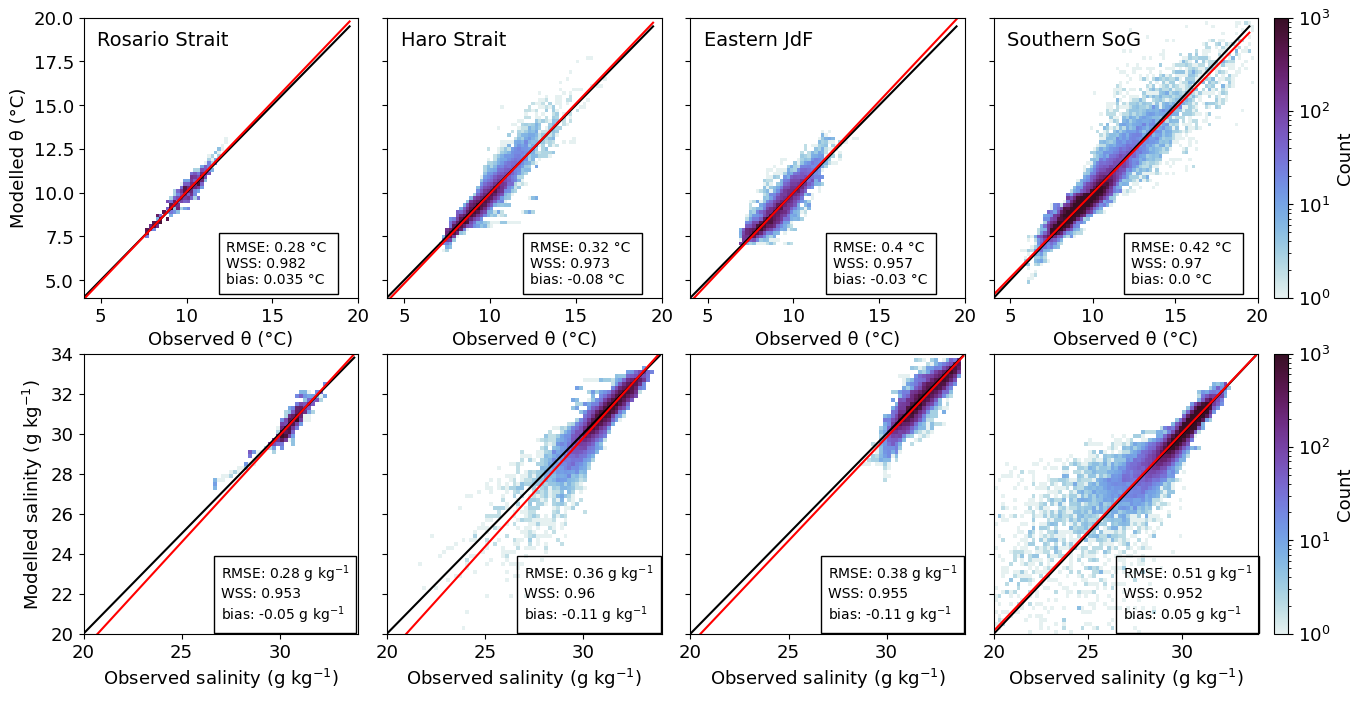

In [13]:
cmap = cm.dense
from matplotlib.patheffects import withStroke
plt.rcParams.update({'font.size': 13})
vmax = 20
vmin = 4
dbin = 0.2

fig,[[ax,ax3,ax5,ax7],[ax2,ax4,ax6,ax8]] = plt.subplots(2,4,figsize=(16,8),gridspec_kw={'width_ratios':[1,1,1,1.2]})
counts, xedges, yedges, color = ax.hist2d(temp_data_ros['consT'],temp_data_ros['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed {theta_sym} (°C)')
ax.set_ylabel(f'Modelled {theta_sym} (°C)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ros,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')
ax.set_ylim([4,20])
ax.set_xlim([4,20])

counts, xedges, yedges, color = ax2.hist2d(sal_data_ros['SA'],sal_data_ros['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g kg$^{{-1}}$)')
ax2.set_ylabel('Modelled salinity (g kg$^{{-1}}$)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(20,34,0.2),np.arange(20,34,0.2),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ros,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.2)*b1
ax2.plot(np.arange(20, 34, 0.2),line,'r')
ax2.set_ylim([20,34])
ax2.set_xlim([20,34])

counts, xedges, yedges, color = ax3.hist2d(temp_data_haro['consT'],temp_data_haro['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax3.set_xlabel(f'Observed {theta_sym} (°C)')
# ax3.set_ylabel(f'Modelled {theta_sym} (°C)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax3)
ax3.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_haro,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax3.plot(np.arange(vmin, vmax, 0.5),line,'r')
ax3.set_ylim([4,20])
ax3.set_xlim([4,20])
ax3.set_yticklabels([])

counts, xedges, yedges, color = ax4.hist2d(sal_data_haro['SA'],sal_data_haro['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax4.set_xlabel('Observed salinity (g kg$^{{-1}}$)')
# ax4.set_ylabel('Modelled salinity (g/kg)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax4)
ax4.plot(np.arange(20,34,0.1),np.arange(20,34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_haro,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax4.plot(np.arange(20, 34, 0.1),line,'r')
ax4.set_ylim([20,34])
ax4.set_xlim([20,34])
ax4.set_yticklabels([])

counts, xedges, yedges, color = ax5.hist2d(temp_data_ejdf['consT'],temp_data_ejdf['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax5.set_xlabel(f'Observed {theta_sym} (°C)')
# ax5.set_ylabel(f'Modelled {theta_sym} (°C)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax5)
ax5.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ejdf,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax5.plot(np.arange(vmin, vmax, 0.5),line,'r')
ax5.set_ylim([4,20])
ax5.set_xlim([4,20])
ax5.set_yticklabels([])

counts, xedges, yedges, color = ax6.hist2d(sal_data_ejdf['SA'],sal_data_ejdf['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax6.set_xlabel('Observed salinity (g kg$^{{-1}}$)')
# ax6.set_ylabel('Modelled salinity (g/kg)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax6)
ax6.plot(np.arange(20, 34,0.1),np.arange(20, 34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ejdf,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax6.plot(np.arange(20, 34, 0.1),line,'r')
ax6.set_ylim([20,34])
ax6.set_xlim([20,34])
ax6.set_yticklabels([])

counts, xedges, yedges, color = ax7.hist2d(temp_data_sog['consT'],temp_data_sog['mod_votemper'], 
                                           bins=np.arange(vmin, 20, dbin), norm=LogNorm(), cmap=cmap);
ax7.set_xlabel(f'Observed {theta_sym} (°C)')
# ax7.set_ylabel(f'Modelled {theta_sym} (°C)')
color.set_clim(vmax=1000)
cb = fig.colorbar(color, ax=ax7)
cb.set_label('Count')
ax7.plot(np.arange(0,20,0.5),np.arange(0,20,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_sog,'consT','mod_votemper')
line = a1+np.arange(vmin, 20, 0.5)*b1
ax7.plot(np.arange(vmin, 20, 0.5),line,'r')
ax7.set_ylim([4,20])
ax7.set_xlim([4,20])
ax7.set_yticklabels([])

counts, xedges, yedges, color = ax8.hist2d(sal_data_sog['SA'],sal_data_sog['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax8.set_xlabel(f'Observed salinity (g kg$^{{-1}}$)')
# ax8.set_ylabel('Modelled salinity (g/kg)')
color.set_clim(vmax=1000)
cb = fig.colorbar(color, ax=ax8)
cb.set_label('Count')
ax8.plot(np.arange(20, 34,0.1),np.arange(20, 34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_sog,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax8.plot(np.arange(20, 34, 0.1),line,'r')
ax8.set_ylim([20,34])
ax8.set_xlim([20,34])
ax8.set_yticklabels([])


display(d_sal_sog.style.format(myformat).apply(highlight_max_min))
display(d_temp_sog.style.format(myformat).apply(highlight_max_min))

# ax.text(0.5, 0.9, 'Rosario Strait', ha='center', va='center', fontsize=16)
# ax3.text(0.5, 0.7, 'Haro Strait', ha='center', va='center', fontsize=16)
# ax5.text(0.5, 0.48, 'Eastern JdF', ha='center', va='center', fontsize=16)
# ax7.text(0.5, 0.28, 'Southern SoG', ha='center', va='center', fontsize=16)

ax.text(0.05, 0.9, "Rosario Strait", transform=ax.transAxes, fontsize=14)
ax3.text(0.05, 0.9, "Haro Strait", transform=ax3.transAxes, fontsize=14)
ax5.text(0.05, 0.9, "Eastern JdF", transform=ax5.transAxes, fontsize=14)
ax7.text(0.05, 0.9, "Southern SoG", transform=ax7.transAxes, fontsize=14)

met_ros_temp = f"RMSE: {np.round(d_temp_ros['rmse'][0],2)} °C \nWSS: {np.round(d_temp_ros['swillmott'][0],3)} \nbias: {np.round(d_temp_ros['bias'][0],3)} °C"
ax.text(0.52, 0.05, met_ros_temp, transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_haro_temp = f"RMSE: {np.round(d_temp_haro['rmse'][0],2)} °C \nWSS: {np.round(d_temp_haro['swillmott'][0],3)} \nbias: {np.round(d_temp_haro['bias'][0],2)} °C"
ax3.text(0.52, 0.05, met_haro_temp, transform=ax3.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_ejdf_temp = f"RMSE: {np.round(d_temp_ejdf['rmse'][0],2)} °C \nWSS: {np.round(d_temp_ejdf['swillmott'][0],3)} \nbias: {np.round(d_temp_ejdf['bias'][0],2)} °C"
ax5.text(0.52, 0.05, met_ejdf_temp, transform=ax5.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))
met_sog_temp = f"RMSE: {np.round(d_temp_sog['rmse'][0],2)} °C \nWSS: {np.round(d_temp_sog['swillmott'][0],3)} \nbias: {np.round(d_temp_sog['bias'][0],2)} °C"
ax7.text(0.52, 0.05, met_sog_temp, transform=ax7.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_ros_sal = f"RMSE: {np.round(d_sal_ros['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_ros['swillmott'][0],3)} \nbias: {np.round(d_sal_ros['bias'][0],2)} g kg$^{{-1}}$"
ax2.text(0.5, 0.05, met_ros_sal, transform=ax2.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_haro_sal = f"RMSE: {np.round(d_sal_haro['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_haro['swillmott'][0],3)} \nbias: {np.round(d_sal_haro['bias'][0],2)} g kg$^{{-1}}$"
ax4.text(0.5, 0.05, met_haro_sal, transform=ax4.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_ejdf_sal = f"RMSE: {np.round(d_sal_ejdf['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_ejdf['swillmott'][0],3)} \nbias: {np.round(d_sal_ejdf['bias'][0],2)} g kg$^{{-1}}$"
ax6.text(0.5, 0.05, met_ejdf_sal, transform=ax6.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_sog_sal = f"RMSE: {np.round(d_sal_sog['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_sog['swillmott'][0],3)} \nbias: {np.round(d_sal_sog['bias'][0],2)} g kg$^{{-1}}$"
ax8.text(0.49, 0.05, met_sog_sal, transform=ax8.transAxes, fontsize=10,bbox=dict(facecolor='None', edgecolor='black', pad=5))

# ax.text(0.45, -0.24, "(a)", transform=ax.transAxes)
# ax3.text(0.45, -0.24, "(b)", transform=ax3.transAxes)
# ax5.text(0.45, -0.24, "(c)", transform=ax5.transAxes)
# ax7.text(0.45, -0.24, "(d)", transform=ax7.transAxes)

# ax2.text(0.45, -0.24, "(e)", transform=ax2.transAxes)
# ax4.text(0.45, -0.24, "(f)", transform=ax4.transAxes)
# ax6.text(0.45, -0.24, "(g)", transform=ax6.transAxes)
# ax8.text(0.45, -0.24, "(h)", transform=ax8.transAxes)

# Adjust layout
fig.subplots_adjust(wspace=0.1)

### Currents

In [14]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return 1 - (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())
    
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

def wolfram_perp2( obs, mod):
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * obs
    
    nonsyst = np.sqrt(((mod - predictions)**2).mean())
    systematic = np.sqrt(((predictions - obs)**2).mean())
  
    return a1, b1, systematic, nonsyst

def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5)  ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.01)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

def get_stats(temp1, name, idepth, jdepth, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    xr = np.arange(vmin, vmax, 0.01)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}

    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

def get_combined(years, years_og, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False,gridN='None',straitn='_'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        if gridN=='gridV':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/gridV/ObsModel_202111_CIOOS_gridV_{year}0101_{year}1231.csv')
        else:
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_gridU_{year}0101_{year}1231.csv')
    for year in years_og:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}1231.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}0331.csv'
        file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0401_{year}1031.csv'
        file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}1001_{year}1231.csv'
        file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}0430.csv'

        if os.path.exists(file_path1):
            pieces1.append(file_path1)

        if os.path.exists(file_path2):
            pieces1.append(file_path2)

        if os.path.exists(file_path3):
            pieces1.append(file_path3)

        if os.path.exists(file_path4):
            pieces1.append(file_path4)

        if os.path.exists(file_path5):
            pieces1.append(file_path5)

    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        
        if straitn == 'all':
            for ii in ['_','_jdf_']:
                file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}1231.csv'
                file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}0331.csv'
                file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0401_{year}1031.csv'
                file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}1001_{year}1231.csv'
                file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}0430.csv'

                if os.path.exists(file_path1):
                    pieces1.append(file_path1)

                if os.path.exists(file_path2):
                    pieces1.append(file_path2)

                if os.path.exists(file_path3):
                    pieces1.append(file_path3)

                if os.path.exists(file_path4):
                    pieces1.append(file_path4)

                if os.path.exists(file_path5):
                    pieces1.append(file_path5)
            
        else:
            file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}1231.csv'
            file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}0331.csv'
            file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0401_{year}1031.csv'
            file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}1001_{year}1231.csv'
            file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}0430.csv'

            if os.path.exists(file_path1):
                pieces1.append(file_path1)

            if os.path.exists(file_path2):
                pieces1.append(file_path2)

            if os.path.exists(file_path3):
                pieces1.append(file_path3)

            if os.path.exists(file_path4):
                pieces1.append(file_path4)

            if os.path.exists(file_path5):
                pieces1.append(file_path5)
            

    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    # data_filter = temp1[temp1[modn].notna()]
    # print(data_filter)
    d202111 = get_stats(filter_bad_data(temp1),field , idepth, jdepth, whichdepths, reverse, string)
    
    return temp1,d202111

### SoG

In [15]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_sog,d_uvel_sog = get_combined([2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')

d_uvel_sog.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.00268,0.132,0.132,0.63,0.68,0.00215,0.104,0.0689,0.731


In [16]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_sog,d_vvel_sog = get_combined([2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel_sog.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,116054,-0.0163,0.0965,0.0951,0.865,-0.293,-0.00827,0.0396,0.104,-0.496


In [17]:
data_uvel_sog['mod_east_vel'] = data_uvel_sog['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_sog['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_sog['mod_north_vel'] = data_uvel_sog['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_sog['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel = get_stats(filter_bad_data(data_uvel_sog),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel = get_stats(filter_bad_data(data_vvel_sog),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel.style.format(myformat).apply(highlight_max_min))
display(d_vvel.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,117679,0.0113,0.0887,0.088,0.881,0.257,0.0153,0.0415,0.071,0.416


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,116054,-0.00784,0.0845,0.0841,0.871,0.00822,-0.00806,0.0079,0.0838,0.0132


In [18]:
data_uvel_sog['dtime'] = pd.to_datetime(data_uvel_sog['dtUTC'])
data_uvel_sog_2021 = data_uvel_sog[data_uvel_sog['dtime'].dt.year == 2022]

data_vvel_sog['dtime'] = pd.to_datetime(data_vvel_sog['dtUTC'])
data_vvel_sog_2021 = data_vvel_sog[data_vvel_sog['dtime'].dt.year == 2022]

In [19]:
modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_sog21 = get_stats(data_uvel_sog_2021,'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_uvel_sog21.style.format(myformat).apply(highlight_max_min))

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_sog21 = get_stats(data_vvel_sog_2021,'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_vvel_sog21.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,45337,0.00637,0.0817,0.0814,0.92,0.229,0.0152,0.0382,0.0653,0.366


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,45338,-0.00772,0.0758,0.0754,0.851,-0.491,0.00255,0.0432,0.0843,-0.864


#### ONC - JdF

#### JdF 

In [20]:
def get_combined_v2(years, years_og, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False,gridN='None',straitn='_'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        if gridN=='gridV':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/gridV/ObsModel_202111_CIOOS_gridV_{year}0101_{year}1231.csv')
        else:
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_gridU_{year}0101_{year}1231.csv')
    for year in years_og:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}1231_k29.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}0331_k29.csv'
        file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0401_{year}1031_k29.csv'
        file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}1001_{year}1231_k29.csv'
        file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}0430_k29.csv'

        if os.path.exists(file_path1):
            pieces1.append(file_path1)

        if os.path.exists(file_path2):
            pieces1.append(file_path2)

        if os.path.exists(file_path3):
            pieces1.append(file_path3)

        if os.path.exists(file_path4):
            pieces1.append(file_path4)

        if os.path.exists(file_path5):
            pieces1.append(file_path5)

    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        
        if straitn == 'all':
            for ii in ['_','_jdf_']:
                file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}1231_v2.csv'

                if os.path.exists(file_path1):
                    pieces1.append(file_path1)
            
        else:
            file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}1231_v2.csv'

            if os.path.exists(file_path1):
                pieces1.append(file_path1)
            

    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    # data_filter = temp1[temp1[modn].notna()]
    # print(data_filter)
    d202111 = get_stats(filter_bad_data(temp1),field , idepth, jdepth, whichdepths, reverse, string)
    
    return temp1,d202111

In [21]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 1.5
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel,d_uvel = get_combined([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_uvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,345764,0.0321,0.343,0.341,0.687,-0.691,-0.112,0.201,0.443,-0.71


In [22]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel,d_vvel = get_combined([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,-0.046,0.23,0.225,0.761,0.369,0.00181,0.115,0.172,0.444


In [23]:
data_uvel['mod_east_vel'] = data_uvel['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel['mod_north_vel'] = data_uvel['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel = get_stats(filter_bad_data(data_uvel),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

data_vvel_d = data_vvel[data_vvel['mod_north_vel'].notna()]
d_vvel = get_stats(filter_bad_data(data_vvel_d),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel.style.format(myformat).apply(highlight_max_min))
display(d_vvel.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0386,0.345,0.342,0.67,-0.642,-0.172,0.188,0.441,-0.602


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0596,0.308,0.303,0.581,0.435,0.116,0.137,0.236,0.325


In [24]:
data_uvel['dtime'] = pd.to_datetime(data_uvel['dtUTC'])
data_uvel_2020 = data_uvel[data_uvel['dtime'].dt.year == 2020]

In [25]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 1.5
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_jdf_v2,d_uvel_jdf_v2 = get_combined_v2([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn,straitn='_jdf_')

display(d_uvel_jdf_v2.style.format(myformat).apply(highlight_max_min))

field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_jdf_v2,d_vvel_jdf_v2 = get_combined_v2([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2020]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn,straitn='_jdf_')

d_vvel_jdf_v2.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,26492,0.0358,0.192,0.188,0.927,0.0165,0.0364,0.0363,0.187,0.0283


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,26492,-0.0473,0.24,0.236,0.738,0.472,-0.00723,0.148,0.16,0.558


In [26]:
data_uvel_jdf_v2['mod_east_vel'] = data_uvel_jdf_v2['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_jdf_v2['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_jdf_v2['mod_north_vel'] = data_uvel_jdf_v2['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_jdf_v2['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_jdf_v2 = get_stats(filter_bad_data(data_uvel_jdf_v2),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

data_vvel_jdf_v2 = data_vvel_jdf_v2[data_vvel_jdf_v2['mod_north_vel'].notna()]
d_vvel_jdf_v2 = get_stats(filter_bad_data(data_vvel_jdf_v2),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_jdf_v2.style.format(myformat).apply(highlight_max_min))
display(d_vvel_jdf_v2.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,26492,0.00872,0.153,0.153,0.949,0.114,0.0127,0.0425,0.139,0.197


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,26492,-0.0178,0.139,0.138,0.932,0.184,-0.00221,0.0575,0.116,0.303


In [27]:
data_uvel_jdf_v2['dtime'] = pd.to_datetime(data_uvel_jdf_v2['dtUTC'])
data_vvel_jdf_v2['dtime'] = pd.to_datetime(data_vvel_jdf_v2['dtUTC'])

### Boundary Pass

In [28]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_k29,d_uvel_k29 = get_combined_v2([]
                                          , [2020]
                                          , []#
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

display(d_uvel_k29.style.format(myformat).apply(highlight_max_min))

# plt.scatter(data_uvel_2012['mod_vozocrtx'],data_uvel_OG['mod_vozocrtx'],s=1)
# plt.plot(np.arange(-1,1,0.1),np.arange(-1,1,0.1),'k')

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,0.00916,0.398,0.398,0.624,-1.62,-0.312,0.439,0.65,-1.57


In [29]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_k29,d_vvel_k29 = get_combined_v2([]#[2008,2009,2010,2012,2021,2022]
                                          , [2020]#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel_k29.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,-0.0926,0.268,0.252,0.719,0.385,-0.0287,0.148,0.193,0.436


In [30]:
data_uvel_k29['mod_east_vel'] = data_uvel_k29['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_k29['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_k29['mod_north_vel'] = data_uvel_k29['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_k29['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_k29 = get_stats(filter_bad_data(data_uvel_k29),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_k29 = get_stats(filter_bad_data(data_vvel_k29),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_k29.style.format(myformat).apply(highlight_max_min))
display(d_vvel_k29.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,-0.0523,0.329,0.325,0.646,-0.575,-0.166,0.164,0.412,-0.49


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,-0.00166,0.277,0.277,0.802,-0.314,-0.0538,0.0943,0.312,-0.439


In [31]:
data_uvel_k29['dtime'] = pd.to_datetime(data_uvel_k29['dtUTC'])
data_vvel_k29['dtime'] = pd.to_datetime(data_vvel_k29['dtUTC'])

In [32]:
data_uvel_k2930 = data_uvel_k29.copy()
data_vvel_k2930 = data_vvel_k29.copy()

data_uvel_k2930['mod_east_vel'] = data_uvel_2020['mod_vozocrtx'].values*np.cos(np.deg2rad(29)) - data_vvel_k29['mod_vomecrty'].values*np.sin(np.deg2rad(29))
data_vvel_k2930['mod_north_vel'] = data_uvel_2020['mod_vozocrtx'].values*np.sin(np.deg2rad(29)) + data_vvel_k29['mod_vomecrty'].values*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_k2930 = get_stats(filter_bad_data(data_uvel_k2930),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_k2930 = get_stats(filter_bad_data(data_vvel_k2930),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_k2930.style.format(myformat).apply(highlight_max_min))
display(d_vvel_k2930.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,-0.0238,0.287,0.286,0.687,-0.12,-0.0475,0.0402,0.302,-0.113


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,0.0142,0.261,0.26,0.816,-0.207,-0.0202,0.0637,0.283,-0.292


### Resample to hourly from observations

In [33]:
data_uvel_k2930.set_index('dtime',inplace=True)

In [34]:
data_uvel_resamp = data_uvel_k2930[['current_velocity_east','mod_east_vel','Lat','Lon','Z','k']]
data_uvel_resamp = data_uvel_resamp.resample('h').mean()

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_resamp = get_stats(filter_bad_data(data_uvel_resamp),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_resamp)
display(d_uvel_k2930)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,8736,-0.023776,0.263883,0.26281,0.712213,-0.325135,-0.087993,0.083424,0.301968,-0.34247


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,-0.023801,0.286578,0.285588,0.6867,-0.119783,-0.047458,0.04017,0.302309,-0.112844


In [35]:
data_vvel_k2930.set_index('dtime',inplace=True)

In [36]:
data_vvel_resamp = data_vvel_k2930[['current_velocity_north','mod_north_vel','Lat','Lon','Z','k']]
data_vvel_resamp = data_vvel_resamp.resample('h').mean()

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_resamp = get_stats(filter_bad_data(data_vvel_resamp),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_vvel_resamp)
display(d_vvel_k2930)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,8736,0.01417,0.238057,0.237635,0.838891,-0.305313,-0.03651,0.087014,0.263864,-0.474628


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,0.014158,0.26058,0.260195,0.816451,-0.20681,-0.020177,0.063738,0.283056,-0.291536


In [37]:
data_uvel_jdf_v2.set_index('dtime',inplace=True)

In [38]:
data_uvel_jdf_resamp = data_uvel_jdf_v2[['current_velocity_east','mod_east_vel','Lat','Lon','Z','k']]
data_uvel_jdf_resamp = data_uvel_jdf_resamp.resample('h').mean()

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_jdf_resamp = get_stats(filter_bad_data(data_uvel_jdf_resamp),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_jdf_resamp)
display(d_uvel_jdf_v2)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,4416,0.008707,0.125928,0.125627,0.964937,0.082769,0.011582,0.030633,0.117401,0.149253


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,26492,0.00872,0.152923,0.152674,0.949345,0.113908,0.012682,0.042513,0.139233,0.197356


In [39]:
data_vvel_jdf_v2.set_index('dtime',inplace=True)

In [40]:
data_vvel_jdf_resamp = data_vvel_jdf_v2[['current_velocity_north','mod_north_vel','Lat','Lon','Z','k']]
data_vvel_jdf_resamp = data_vvel_jdf_resamp.resample('h').mean()

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_jdf_resamp = get_stats(filter_bad_data(data_vvel_jdf_resamp),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_vvel_jdf_resamp)
display(d_vvel_jdf_v2)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,4416,-0.017815,0.117576,0.116218,0.950423,0.14953,-0.005123,0.046652,0.100746,0.2571


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,26492,-0.01781,0.138937,0.137791,0.932407,0.183702,-0.002214,0.057517,0.116428,0.303033


In [41]:
data_uvel_sog_2021.set_index('dtime',inplace=True)

In [42]:
data_uvel_sog_resamp = data_uvel_sog_2021[['current_velocity_east','mod_east_vel','Lat','Lon','Z','k']]
data_uvel_sog_resamp = data_uvel_sog_resamp.resample('h').mean()

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_sog_resamp = get_stats(filter_bad_data(data_uvel_sog_resamp),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_sog_resamp)
display(d_uvel_sog21)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,7557,0.006371,0.078469,0.07821,0.924601,0.221068,0.014851,0.036477,0.063046,0.356408


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,45337,0.006366,0.081679,0.08143,0.919523,0.2292,0.015157,0.038228,0.065305,0.365714


In [43]:
data_vvel_sog_2021.set_index('dtime',inplace=True)

In [44]:
data_vvel_sog_resamp = data_vvel_sog_2021[['current_velocity_north','mod_north_vel','Lat','Lon','Z','k']]
data_vvel_sog_resamp = data_vvel_sog_resamp.resample('h').mean()

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_sog_resamp = get_stats(filter_bad_data(data_vvel_sog_resamp),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_vvel_sog_resamp)
display(d_vvel_sog21)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,7557,-0.007709,0.072581,0.07217,0.860967,-0.520114,0.003168,0.044476,0.079358,-0.959219


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,45338,-0.007721,0.075779,0.075384,0.850896,-0.491491,0.00255,0.043198,0.084311,-0.863567


#### Figure 

(-1.5, 1.8)

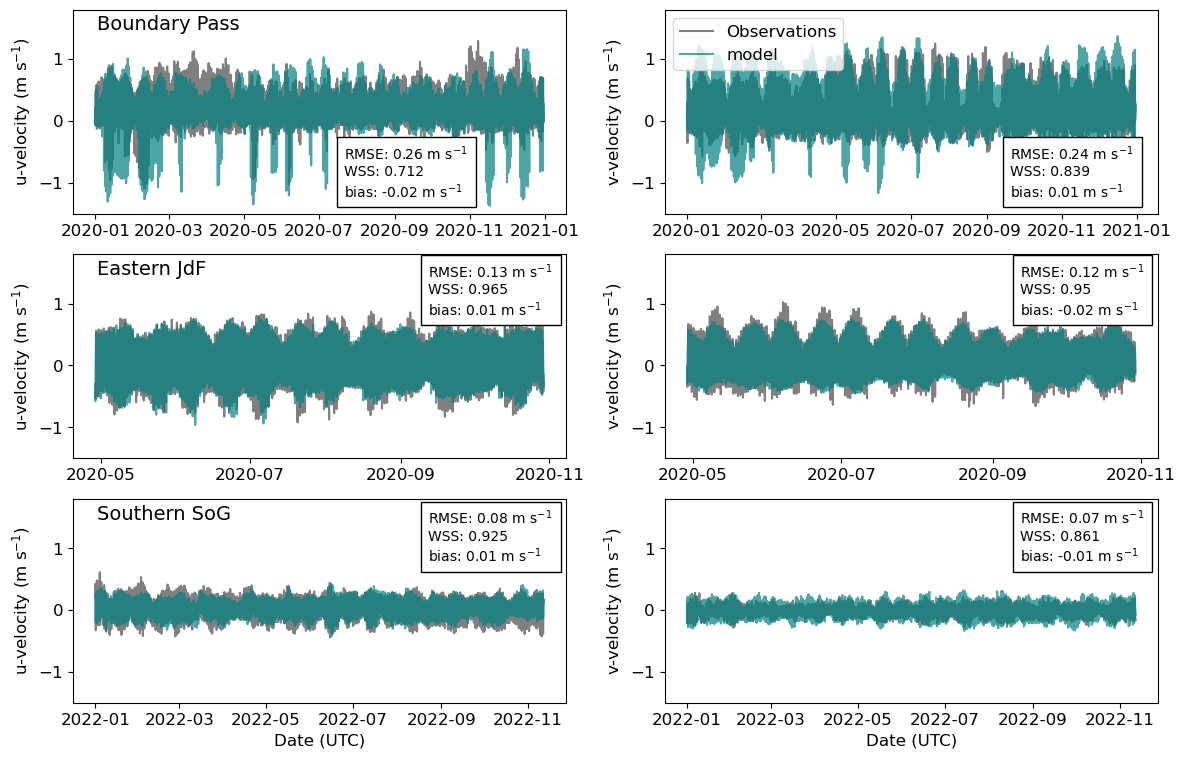

In [45]:
import matplotlib.dates as mdates
plt.rcParams['font.size'] = 12

fig,[[ax,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(14,9))

ax.plot(data_uvel_resamp.index,data_uvel_resamp['current_velocity_east'],color='grey',label='Observations')
ax.plot(data_uvel_resamp.index,data_uvel_resamp['mod_east_vel'],color='teal',label='model',alpha=0.7)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_ylabel(f'u-velocity (m s$^{{-1}}$)')

ax2.plot(data_vvel_resamp.index,data_vvel_resamp['current_velocity_north'],color='grey',label='Observations')
ax2.plot(data_vvel_resamp.index,data_vvel_resamp['mod_north_vel'],color='teal',label='model',alpha=0.7)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.set_ylabel(f'v-velocity (m s$^{{-1}}$)')
ax2.legend(loc=2)

ax3.plot(data_uvel_jdf_resamp.index,data_uvel_jdf_resamp['current_velocity_east'],color='grey')
ax3.plot(data_uvel_jdf_resamp.index,data_uvel_jdf_resamp['mod_east_vel'],color='teal',alpha=0.7)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.set_ylabel(f'u-velocity (m s$^{{-1}}$)')

ax4.plot(data_vvel_jdf_resamp.index,data_vvel_jdf_resamp['current_velocity_north'],color='grey')
ax4.plot(data_vvel_jdf_resamp.index,data_vvel_jdf_resamp['mod_north_vel'],color='teal',alpha=0.7)
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax4.set_ylabel(f'v-velocity (m s$^{{-1}}$)')

ax5.plot(data_uvel_sog_resamp.index,data_uvel_sog_resamp['current_velocity_east'],color='grey')
ax5.plot(data_uvel_sog_resamp.index,data_uvel_sog_resamp['mod_east_vel'],color='teal',alpha=0.7)
ax5.set_ylabel(f'u-velocity (m s$^{{-1}}$)')
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax5.set_xlabel('Date (UTC)')

ax6.plot(data_vvel_sog_resamp.index,data_vvel_sog_resamp['current_velocity_north'],color='grey')
ax6.plot(data_vvel_sog_resamp.index,data_vvel_sog_resamp['mod_north_vel'],color='teal',alpha=0.7)
ax6.set_ylabel(f'v-velocity (m s$^{{-1}}$)')
ax6.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax6.set_xlabel('Date (UTC)')
# ax.legend(loc=4)

ax.text(0.05, 0.9, "Boundary Pass", transform=ax.transAxes, fontsize=14)
ax3.text(0.05, 0.9, "Eastern JdF", transform=ax3.transAxes, fontsize=14)
ax5.text(0.05, 0.9, "Southern SoG", transform=ax5.transAxes, fontsize=14)

met_bp_uvel = f"RMSE: {np.round(d_uvel_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_uvel_resamp['swillmott'][0],3)} \nbias: {np.round(d_uvel_resamp['bias'][0],2)} m s$^{{-1}}$"
ax.text(0.55, 0.08, met_bp_uvel, transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_bp_vvel = f"RMSE: {np.round(d_vvel_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_vvel_resamp['swillmott'][0],3)} \nbias: {np.round(d_vvel_resamp['bias'][0],2)} m s$^{{-1}}$"
ax2.text(0.70, 0.08, met_bp_vvel, transform=ax2.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_jdf_uvel = f"RMSE: {np.round(d_uvel_jdf_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_uvel_jdf_resamp['swillmott'][0],3)} \nbias: {np.round(d_uvel_jdf_resamp['bias'][0],2)} m s$^{{-1}}$"
ax3.text(0.72, 0.7, met_jdf_uvel, transform=ax3.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_jdf_vvel = f"RMSE: {np.round(d_vvel_jdf_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_vvel_jdf_resamp['swillmott'][0],3)} \nbias: {np.round(d_vvel_jdf_resamp['bias'][0],2)} m s$^{{-1}}$"
ax4.text(0.72, 0.7, met_jdf_vvel, transform=ax4.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_sog_uvel = f"RMSE: {np.round(d_uvel_sog_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_uvel_sog_resamp['swillmott'][0],3)} \nbias: {np.round(d_uvel_sog_resamp['bias'][0],2)} m s$^{{-1}}$"
ax5.text(0.72, 0.69, met_sog_uvel, transform=ax5.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_sog_vvel = f"RMSE: {np.round(d_vvel_sog_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_vvel_sog_resamp['swillmott'][0],3)} \nbias: {np.round(d_vvel_sog_resamp['bias'][0],2)} m s$^{{-1}}$"
ax6.text(0.72, 0.69, met_sog_vvel, transform=ax6.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

ax.set_ylim([-1.5,1.8])
ax2.set_ylim([-1.5,1.8])
ax3.set_ylim([-1.5,1.8])
ax4.set_ylim([-1.5,1.8])
ax5.set_ylim([-1.5,1.8])
ax6.set_ylim([-1.5,1.8])
# fig.subplots_adjust(hspace=0.32)

### Combined figure

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,142187,0.0456,0.513,0.511,0.952,0.01,0.348,0.0472,0.508,0.0203


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,142187,0.00329,0.422,0.422,0.97,0.0357,0.337,0.0445,0.412,0.063


Text(0.0145, 0.9305, 'n')

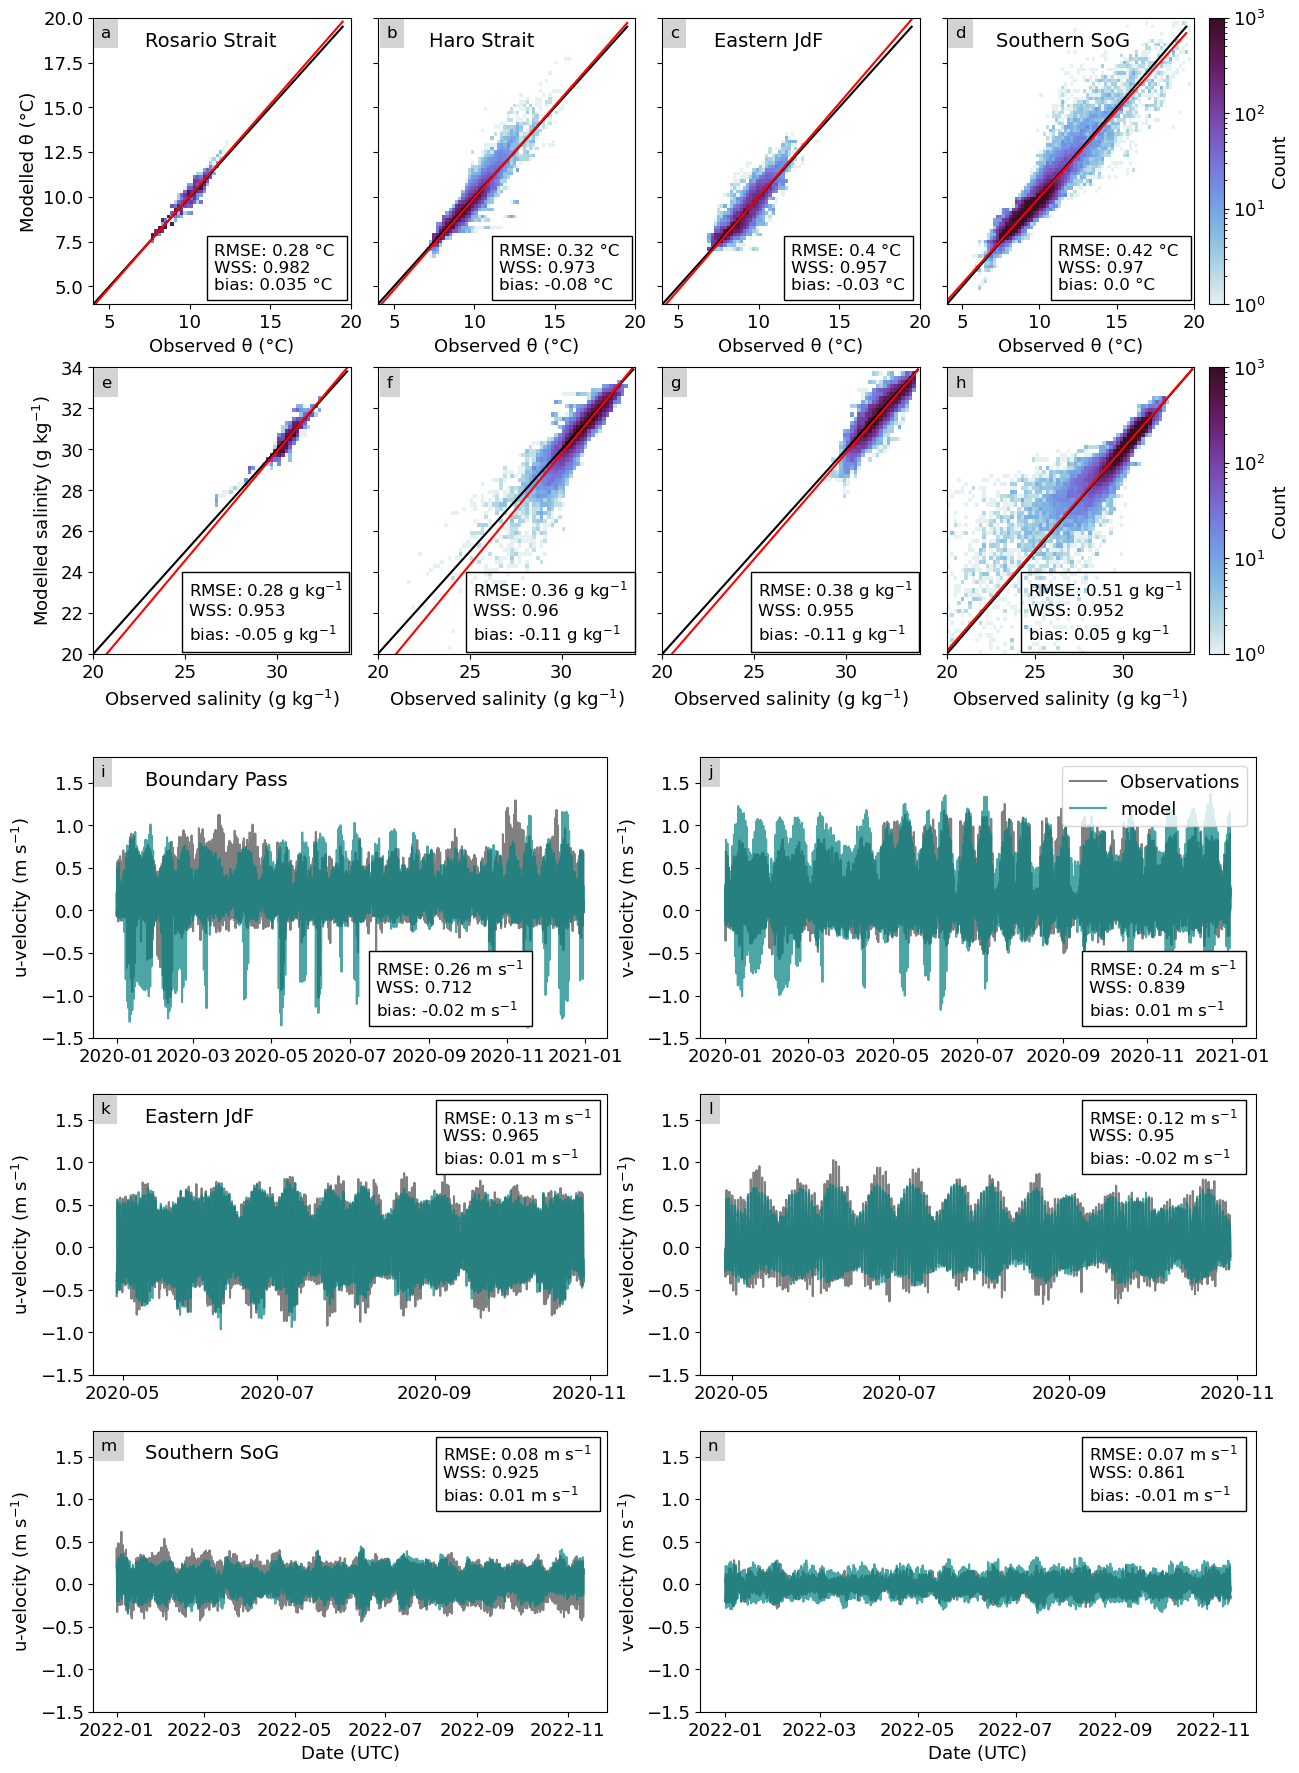

In [52]:
cmap = cm.dense
from matplotlib.patheffects import withStroke
plt.rcParams.update({'font.size': 13})
vmax = 20
vmin = 4
dbin = 0.2


fig = plt.figure(figsize=(15,22))
gs_parent = fig.add_gridspec(2, 1, height_ratios=[0.4, 0.6], hspace=0.13)
gs_top = gs_parent[0].subgridspec(2, 4, width_ratios=[1, 1, 1, 1.2], hspace=0.22, wspace=0.1)
gs_bottom = gs_parent[1].subgridspec(3, 4, width_ratios=[1, 1, 1, 1.2], hspace=0.2, wspace=0.42)


# gs = fig.add_gridspec(5, 4, width_ratios=[1, 1, 1, 1.2])
# gs_top = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1.2], hspace=0.27, wspace=0.1,bottom=0.54)
# gs_bottom = fig.add_gridspec(3, 4, width_ratios=[1, 1, 1, 1.2], hspace=0.25, wspace=0.32,top=0.48)

ax = fig.add_subplot(gs_top[0, 0])
ax3 = fig.add_subplot(gs_top[0, 1])
ax5 = fig.add_subplot(gs_top[0, 2])
ax7 = fig.add_subplot(gs_top[0, 3])
ax2 = fig.add_subplot(gs_top[1, 0])
ax4 = fig.add_subplot(gs_top[1, 1])
ax6 = fig.add_subplot(gs_top[1, 2])
ax8 = fig.add_subplot(gs_top[1, 3])
ax9 = fig.add_subplot(gs_bottom[0,0:2])
ax10 = fig.add_subplot(gs_bottom[0, 2:])
ax11 = fig.add_subplot(gs_bottom[1, :2])
ax12 = fig.add_subplot(gs_bottom[1, 2:])
ax13 = fig.add_subplot(gs_bottom[2, :2])
ax14 = fig.add_subplot(gs_bottom[2, 2:])

counts, xedges, yedges, color = ax.hist2d(temp_data_ros['consT'],temp_data_ros['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed {theta_sym} (°C)')
ax.set_ylabel(f'Modelled {theta_sym} (°C)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ros,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')
ax.set_ylim([4,20])
ax.set_xlim([4,20])

counts, xedges, yedges, color = ax2.hist2d(sal_data_ros['SA'],sal_data_ros['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g kg$^{{-1}}$)')
ax2.set_ylabel('Modelled salinity (g kg$^{{-1}}$)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(20,34,0.2),np.arange(20,34,0.2),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ros,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.2)*b1
ax2.plot(np.arange(20, 34, 0.2),line,'r')
ax2.set_ylim([20,34])
ax2.set_xlim([20,34])

counts, xedges, yedges, color = ax3.hist2d(temp_data_haro['consT'],temp_data_haro['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax3.set_xlabel(f'Observed {theta_sym} (°C)')
# ax3.set_ylabel(f'Modelled {theta_sym} (°C)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax3)
ax3.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_haro,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax3.plot(np.arange(vmin, vmax, 0.5),line,'r')
ax3.set_ylim([4,20])
ax3.set_xlim([4,20])
ax3.set_yticklabels([])

counts, xedges, yedges, color = ax4.hist2d(sal_data_haro['SA'],sal_data_haro['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax4.set_xlabel('Observed salinity (g kg$^{{-1}}$)')
# ax4.set_ylabel('Modelled salinity (g/kg)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax4)
ax4.plot(np.arange(20,34,0.1),np.arange(20,34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_haro,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax4.plot(np.arange(20, 34, 0.1),line,'r')
ax4.set_ylim([20,34])
ax4.set_xlim([20,34])
ax4.set_yticklabels([])

counts, xedges, yedges, color = ax5.hist2d(temp_data_ejdf['consT'],temp_data_ejdf['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax5.set_xlabel(f'Observed {theta_sym} (°C)')
# ax5.set_ylabel(f'Modelled {theta_sym} (°C)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax5)
ax5.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ejdf,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax5.plot(np.arange(vmin, vmax, 0.5),line,'r')
ax5.set_ylim([4,20])
ax5.set_xlim([4,20])
ax5.set_yticklabels([])

counts, xedges, yedges, color = ax6.hist2d(sal_data_ejdf['SA'],sal_data_ejdf['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax6.set_xlabel('Observed salinity (g kg$^{{-1}}$)')
# ax6.set_ylabel('Modelled salinity (g/kg)')
# color.set_clim(vmax=1000)
# fig.colorbar(color, ax=ax6)
ax6.plot(np.arange(20, 34,0.1),np.arange(20, 34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ejdf,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax6.plot(np.arange(20, 34, 0.1),line,'r')
ax6.set_ylim([20,34])
ax6.set_xlim([20,34])
ax6.set_yticklabels([])

counts, xedges, yedges, color = ax7.hist2d(temp_data_sog['consT'],temp_data_sog['mod_votemper'], 
                                           bins=np.arange(vmin, 20, dbin), norm=LogNorm(), cmap=cmap);
ax7.set_xlabel(f'Observed {theta_sym} (°C)')
# ax7.set_ylabel(f'Modelled {theta_sym} (°C)')
color.set_clim(vmax=1000)
cb = fig.colorbar(color, ax=ax7)
cb.set_label('Count')
ax7.plot(np.arange(0,20,0.5),np.arange(0,20,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_sog,'consT','mod_votemper')
line = a1+np.arange(vmin, 20, 0.5)*b1
ax7.plot(np.arange(vmin, 20, 0.5),line,'r')
ax7.set_ylim([4,20])
ax7.set_xlim([4,20])
ax7.set_yticklabels([])

counts, xedges, yedges, color = ax8.hist2d(sal_data_sog['SA'],sal_data_sog['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax8.set_xlabel(f'Observed salinity (g kg$^{{-1}}$)')
# ax8.set_ylabel('Modelled salinity (g/kg)')
color.set_clim(vmax=1000)
cb = fig.colorbar(color, ax=ax8)
cb.set_label('Count')
ax8.plot(np.arange(20, 34,0.1),np.arange(20, 34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_sog,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax8.plot(np.arange(20, 34, 0.1),line,'r')
ax8.set_ylim([20,34])
ax8.set_xlim([20,34])
ax8.set_yticklabels([])


display(d_sal_sog.style.format(myformat).apply(highlight_max_min))
display(d_temp_sog.style.format(myformat).apply(highlight_max_min))

# ax.text(0.5, 0.9, 'Rosario Strait', ha='center', va='center', fontsize=16)
# ax3.text(0.5, 0.7, 'Haro Strait', ha='center', va='center', fontsize=16)
# ax5.text(0.5, 0.48, 'Eastern JdF', ha='center', va='center', fontsize=16)
# ax7.text(0.5, 0.28, 'Southern SoG', ha='center', va='center', fontsize=16)

ax.text(0.2, 0.9, "Rosario Strait", transform=ax.transAxes, fontsize=14)
ax3.text(0.2, 0.9, "Haro Strait", transform=ax3.transAxes, fontsize=14)
ax5.text(0.2, 0.9, "Eastern JdF", transform=ax5.transAxes, fontsize=14)
ax7.text(0.2, 0.9, "Southern SoG", transform=ax7.transAxes, fontsize=14)

met_ros_temp = f"RMSE: {np.round(d_temp_ros['rmse'][0],2)} °C \nWSS: {np.round(d_temp_ros['swillmott'][0],3)} \nbias: {np.round(d_temp_ros['bias'][0],3)} °C"
ax.text(0.47, 0.05, met_ros_temp, transform=ax.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_haro_temp = f"RMSE: {np.round(d_temp_haro['rmse'][0],2)} °C \nWSS: {np.round(d_temp_haro['swillmott'][0],3)} \nbias: {np.round(d_temp_haro['bias'][0],2)} °C"
ax3.text(0.47, 0.05, met_haro_temp, transform=ax3.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_ejdf_temp = f"RMSE: {np.round(d_temp_ejdf['rmse'][0],2)} °C \nWSS: {np.round(d_temp_ejdf['swillmott'][0],3)} \nbias: {np.round(d_temp_ejdf['bias'][0],2)} °C"
ax5.text(0.50, 0.05, met_ejdf_temp, transform=ax5.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))
met_sog_temp = f"RMSE: {np.round(d_temp_sog['rmse'][0],2)} °C \nWSS: {np.round(d_temp_sog['swillmott'][0],3)} \nbias: {np.round(d_temp_sog['bias'][0],2)} °C"
ax7.text(0.45, 0.05, met_sog_temp, transform=ax7.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_ros_sal = f"RMSE: {np.round(d_sal_ros['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_ros['swillmott'][0],3)} \nbias: {np.round(d_sal_ros['bias'][0],2)} g kg$^{{-1}}$"
ax2.text(0.37, 0.05, met_ros_sal, transform=ax2.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_haro_sal = f"RMSE: {np.round(d_sal_haro['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_haro['swillmott'][0],3)} \nbias: {np.round(d_sal_haro['bias'][0],2)} g kg$^{{-1}}$"
ax4.text(0.37, 0.05, met_haro_sal, transform=ax4.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_ejdf_sal = f"RMSE: {np.round(d_sal_ejdf['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_ejdf['swillmott'][0],3)} \nbias: {np.round(d_sal_ejdf['bias'][0],2)} g kg$^{{-1}}$"
ax6.text(0.37, 0.05, met_ejdf_sal, transform=ax6.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))

met_sog_sal = f"RMSE: {np.round(d_sal_sog['rmse'][0],2)} g kg$^{{-1}}$\nWSS: {np.round(d_sal_sog['swillmott'][0],3)} \nbias: {np.round(d_sal_sog['bias'][0],2)} g kg$^{{-1}}$"
ax8.text(0.33, 0.05, met_sog_sal, transform=ax8.transAxes, fontsize=12,bbox=dict(facecolor='None', edgecolor='black', pad=5))

# ax.text(0.45, -0.24, "(a)", transform=ax.transAxes)
# ax3.text(0.45, -0.24, "(b)", transform=ax3.transAxes)
# ax5.text(0.45, -0.24, "(c)", transform=ax5.transAxes)
# ax7.text(0.45, -0.24, "(d)", transform=ax7.transAxes)

# ax2.text(0.45, -0.24, "(e)", transform=ax2.transAxes)
# ax4.text(0.45, -0.24, "(f)", transform=ax4.transAxes)
# ax6.text(0.45, -0.24, "(g)", transform=ax6.transAxes)
# ax8.text(0.45, -0.24, "(h)", transform=ax8.transAxes)

# Adjust layout
fig.subplots_adjust(wspace=0.1,hspace=0.25)


###############
## Currents
###############

ax9.plot(data_uvel_resamp.index,data_uvel_resamp['current_velocity_east'],color='grey',label='Observations')
ax9.plot(data_uvel_resamp.index,data_uvel_resamp['mod_east_vel'],color='teal',label='model',alpha=0.7)
ax9.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax9.set_ylabel(f'u-velocity (m s$^{{-1}}$)')

ax10.plot(data_vvel_resamp.index,data_vvel_resamp['current_velocity_north'],color='grey',label='Observations')
ax10.plot(data_vvel_resamp.index,data_vvel_resamp['mod_north_vel'],color='teal',label='model',alpha=0.7)
ax10.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax10.set_ylabel(f'v-velocity (m s$^{{-1}}$)')
ax10.legend(loc=1)

ax11.plot(data_uvel_jdf_resamp.index,data_uvel_jdf_resamp['current_velocity_east'],color='grey')
ax11.plot(data_uvel_jdf_resamp.index,data_uvel_jdf_resamp['mod_east_vel'],color='teal',alpha=0.7)
ax11.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax11.set_ylabel(f'u-velocity (m s$^{{-1}}$)')

ax12.plot(data_vvel_jdf_resamp.index,data_vvel_jdf_resamp['current_velocity_north'],color='grey')
ax12.plot(data_vvel_jdf_resamp.index,data_vvel_jdf_resamp['mod_north_vel'],color='teal',alpha=0.7)
ax12.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax12.set_ylabel(f'v-velocity (m s$^{{-1}}$)')

ax13.plot(data_uvel_sog_resamp.index,data_uvel_sog_resamp['current_velocity_east'],color='grey')
ax13.plot(data_uvel_sog_resamp.index,data_uvel_sog_resamp['mod_east_vel'],color='teal',alpha=0.7)
ax13.set_ylabel(f'u-velocity (m s$^{{-1}}$)')
ax13.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax13.set_xlabel('Date (UTC)')

ax14.plot(data_vvel_sog_resamp.index,data_vvel_sog_resamp['current_velocity_north'],color='grey')
ax14.plot(data_vvel_sog_resamp.index,data_vvel_sog_resamp['mod_north_vel'],color='teal',alpha=0.7)
ax14.set_ylabel(f'v-velocity (m s$^{{-1}}$)')
ax14.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax14.set_xlabel('Date (UTC)')
# ax.legend(loc=4)

ax9.text(0.1, 0.9, "Boundary Pass", transform=ax9.transAxes, fontsize=14)
ax11.text(0.1, 0.9, "Eastern JdF", transform=ax11.transAxes, fontsize=14)
ax13.text(0.1, 0.9, "Southern SoG", transform=ax13.transAxes, fontsize=14)

met_bp_uvel = f"RMSE: {np.round(d_uvel_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_uvel_resamp['swillmott'][0],3)} \nbias: {np.round(d_uvel_resamp['bias'][0],2)} m s$^{{-1}}$"
ax9.text(0.55, 0.08, met_bp_uvel, transform=ax9.transAxes, fontsize=12,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_bp_vvel = f"RMSE: {np.round(d_vvel_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_vvel_resamp['swillmott'][0],3)} \nbias: {np.round(d_vvel_resamp['bias'][0],2)} m s$^{{-1}}$"
ax10.text(0.70, 0.08, met_bp_vvel, transform=ax10.transAxes, fontsize=12,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_jdf_uvel = f"RMSE: {np.round(d_uvel_jdf_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_uvel_jdf_resamp['swillmott'][0],3)} \nbias: {np.round(d_uvel_jdf_resamp['bias'][0],2)} m s$^{{-1}}$"
ax11.text(0.68, 0.75, met_jdf_uvel, transform=ax11.transAxes, fontsize=12,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_jdf_vvel = f"RMSE: {np.round(d_vvel_jdf_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_vvel_jdf_resamp['swillmott'][0],3)} \nbias: {np.round(d_vvel_jdf_resamp['bias'][0],2)} m s$^{{-1}}$"
ax12.text(0.7, 0.75, met_jdf_vvel, transform=ax12.transAxes, fontsize=12,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_sog_uvel = f"RMSE: {np.round(d_uvel_sog_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_uvel_sog_resamp['swillmott'][0],3)} \nbias: {np.round(d_uvel_sog_resamp['bias'][0],2)} m s$^{{-1}}$"
ax13.text(0.68, 0.75, met_sog_uvel, transform=ax13.transAxes, fontsize=12,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_sog_vvel = f"RMSE: {np.round(d_vvel_sog_resamp['rmse'][0],2)} m s$^{{-1}}$ \nWSS: {np.round(d_vvel_sog_resamp['swillmott'][0],3)} \nbias: {np.round(d_vvel_sog_resamp['bias'][0],2)} m s$^{{-1}}$"
ax14.text(0.7, 0.75, met_sog_vvel, transform=ax14.transAxes, fontsize=12,bbox=dict(facecolor='w', edgecolor='black', pad=5))

ax9.set_ylim([-1.5,1.8])
ax10.set_ylim([-1.5,1.8])
ax11.set_ylim([-1.5,1.8])
ax12.set_ylim([-1.5,1.8])
ax13.set_ylim([-1.5,1.8])
ax14.set_ylim([-1.5,1.8])
# fig.subplots_adjust(hspace=0.32)

ax.text(0.03, 0.9305, "a", transform=ax.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax3.text(0.035,0.9305, "b", transform=ax3.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax5.text(0.03,0.9305, "c", transform=ax5.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax7.text(0.035,0.9305, "d", transform=ax7.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax2.text(0.03, 0.9305, "e", transform=ax2.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax4.text(0.035, 0.9305, "f", transform=ax4.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax6.text(0.03, 0.9305, "g", transform=ax6.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax8.text(0.035, 0.9305, "h", transform=ax8.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax9.text(0.0145, 0.9305, "i", transform=ax9.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax10.text(0.0145, 0.9305, "j", transform=ax10.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax11.text(0.0145, 0.9305, "k", transform=ax11.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax12.text(0.0145, 0.9305, "l", transform=ax12.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax13.text(0.0145, 0.9305, "m", transform=ax13.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))
ax14.text(0.0145, 0.9305, "n", transform=ax14.transAxes, fontsize=12,bbox=dict(facecolor='lightgrey', edgecolor='None', pad=5))


In [53]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/ME_combined.png',bbox_inches='tight')